In [3]:
from neo4j import GraphDatabase
import getpass
import pandas as pd
import numpy as np
from itertools import combinations
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

In [4]:
uri = "bolt://localhost:7687"
username = "neo4j"
password = getpass.getpass("Enter your Neo4j password: ")

driver = GraphDatabase.driver(uri, auth=(username, password))

def execute_query(driver, query):
    with driver.session() as session:
        result = session.run(query)
        return [record for record in result]

# get ALL nodes and edges WHERE eval_set <> "test"


In [5]:

query_order_nodes = """
MATCH (o:Order)
WHERE o.eval_set <> 'test'
RETURN id(o) as node_id, labels(o) as labels, properties(o) as properties
"""


order_nodes = execute_query(driver, query_order_nodes)
order_nodes

[<Record node_id=0 labels=['Order'] properties={'order_number': '1', 'order_hour_of_day': '8', 'eval_set': 'prior', 'order_dow': '2', 'user_id': '1', 'order_id': '2539329'}>,
 <Record node_id=1 labels=['Order'] properties={'order_number': '2', 'days_since_prior_order': '15.0', 'order_hour_of_day': '7', 'eval_set': 'prior', 'order_dow': '3', 'user_id': '1', 'order_id': '2398795'}>,
 <Record node_id=2 labels=['Order'] properties={'order_number': '3', 'days_since_prior_order': '21.0', 'order_hour_of_day': '12', 'eval_set': 'prior', 'order_dow': '3', 'user_id': '1', 'order_id': '473747'}>,
 <Record node_id=3 labels=['Order'] properties={'order_number': '4', 'days_since_prior_order': '29.0', 'order_hour_of_day': '7', 'eval_set': 'prior', 'order_dow': '4', 'user_id': '1', 'order_id': '2254736'}>,
 <Record node_id=4 labels=['Order'] properties={'order_number': '5', 'days_since_prior_order': '28.0', 'order_hour_of_day': '15', 'eval_set': 'prior', 'order_dow': '4', 'user_id': '1', 'order_id': '

In [6]:

query_product_nodes = """
MATCH (p:Product)
RETURN id(p) as node_id, labels(p) as labels, properties(p) as properties
"""

product_nodes = execute_query(driver, query_product_nodes)
product_nodes

[<Record node_id=3214653 labels=['Product'] properties={'aisle_id': '61', 'product_id': '1', 'department_id': '19', 'product_name': 'Chocolate Sandwich Cookies'}>,
 <Record node_id=3214654 labels=['Product'] properties={'aisle_id': '104', 'product_id': '2', 'department_id': '13', 'product_name': 'All-Seasons Salt'}>,
 <Record node_id=3214655 labels=['Product'] properties={'aisle_id': '94', 'product_id': '3', 'department_id': '7', 'product_name': 'Robust Golden Unsweetened Oolong Tea'}>,
 <Record node_id=3214656 labels=['Product'] properties={'aisle_id': '38', 'product_id': '4', 'department_id': '1', 'product_name': 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce'}>,
 <Record node_id=3214657 labels=['Product'] properties={'aisle_id': '5', 'product_id': '5', 'department_id': '13', 'product_name': 'Green Chile Anytime Sauce'}>,
 <Record node_id=3214658 labels=['Product'] properties={'aisle_id': '11', 'product_id': '6', 'department_id': '11', 'product_name': 'Dry Nose Oi

In [7]:


query_edges =   """
                MATCH (o:Order)-[r:ORDERED]->(p:Product)
                WHERE o.eval_set <> 'test'
                RETURN id(o) as start_node, id(p) as end_node, properties(r) as properties
                """

edges = execute_query(driver, query_edges)

driver.close()




# Product association rules

## A-priori Algorithm 

I did not implement from scratch as I did not think we needed to

In [8]:
product_id_mapping = {product['node_id']: product['properties']['product_name'] for product in product_nodes}
order_id_mapping = {order['node_id']: order['properties']['order_id'] for order in order_nodes}

transactions_dict = {}

for edge in edges:
    order_id = order_id_mapping[edge['start_node']]
    product_name = product_id_mapping[edge['end_node']]
    
    if order_id not in transactions_dict.keys():
        transactions_dict[order_id] = []
    
    transactions_dict[order_id].append(product_name)


transactions = list(transactions_dict.values())
for transaction in transactions:
    transaction.sort()

In [8]:
transactions[:10]

[['Creamy Almond Butter',
  'Organic String Cheese',
  'Original Beef Jerky',
  'Pistachios',
  'Soda'],
 ['Bag of Organic Bananas',
  'Bartlett Pears',
  'Honeycrisp Apples',
  'Organic Fuji Apples',
  'Organic String Cheese',
  'Original Beef Jerky',
  'Pistachios',
  'Soda'],
 ['Cinnamon Toast Crunch',
  'Organic String Cheese',
  'Original Beef Jerky',
  'Pistachios',
  'Soda'],
 ['0% Greek Strained Yogurt',
  'Aged White Cheddar Popcorn',
  'Cinnamon Toast Crunch',
  'Milk Chocolate Almonds',
  'Organic Half & Half',
  'Organic String Cheese',
  'Organic Whole Milk',
  'Pistachios',
  'Soda',
  'XL Pick-A-Size Paper Towel Rolls',
  'Zero Calorie Cola'],
 ['Artichoke Spinach Dip',
  'Banana',
  'Chicken Tikka Masala with Cumin Infused Basmati Rice Frozen Meal',
  'Chipotle Beef & Pork Realstick',
  'Fire Grilled Steak Bowl',
  'Good Belly Probiotics Juice Drink Blueberry Acai Flavor',
  'Hommus Classic Original',
  'Kalamata Olive Spread',
  'Multigrain Flax Seeded Flatbread Cracke

In [9]:
# Just to confirm that there are many empty orders

orders_with_products = {edge['start_node'] for edge in edges}
orders_without_products = set(order_id_mapping.keys()) - orders_with_products

print(f"Number of orders: {len(order_id_mapping)}")
print(f"Number of orders with products: {len(orders_with_products)}")
print(f"Number of orders without products: {len(orders_without_products)}")



Number of orders: 3346083
Number of orders with products: 1279158
Number of orders without products: 2066925


In [10]:

# Initialize TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

df.head()

,#2 Coffee Filters,#2 Cone White Coffee Filters,#2 Mechanical Pencils,#4 Natural Brown Coffee Filters,& Go! Hazelnut Spread + Pretzel Sticks,'Swingtop' Premium Lager,(70% Juice!) Mountain Raspberry Juice Squeeze,+Energy Black Cherry Vegetable & Fruit Juice,".5\"" Waterproof Tape",0 Calorie Acai Raspberry Water Beverage,...,with Twist Ties Sandwich & Storage Bags,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Island Berry Lime 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum,with Xylitol Original Flavor 18 Sticks Sugar Free Gum,with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,with a Splash of Mango Coconut Water,with a Splash of Pineapple Coconut Water
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:

# Adjust the min_support 
min_support_threshold = 0.01
frequent_itemsets = apriori(df, min_support=min_support_threshold, use_colnames=True)

# Adjust the min_threshold 
min_confidence_threshold = 0.04
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence_threshold)


In [1]:
rules

NameError: name 'rules' is not defined

In [36]:

filtered_frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) >= 2)]

filtered_frequent_itemsets.sort_values(by='support', ascending=False).head(10)


,support,itemsets
106,0.019693,"(Organic Strawberries, Bag of Organic Bananas)"
104,0.019182,"(Bag of Organic Bananas, Organic Hass Avocado)"
111,0.017375,"(Banana, Organic Strawberries)"
108,0.016487,"(Banana, Organic Avocado)"
109,0.015904,"(Banana, Organic Baby Spinach)"
103,0.015717,"(Organic Baby Spinach, Bag of Organic Bananas)"
112,0.013080,"(Banana, Strawberries)"
107,0.013071,"(Banana, Large Lemon)"
105,0.012622,"(Bag of Organic Bananas, Organic Raspberries)"
115,0.012555,"(Organic Strawberries, Organic Hass Avocado)"


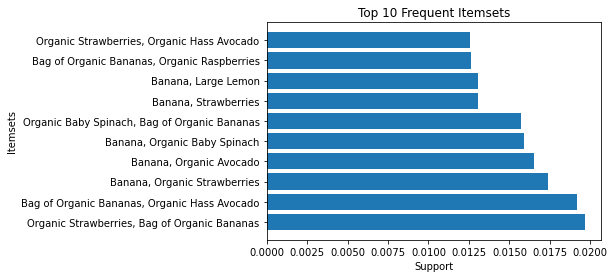

In [40]:
# plot filteeed frequent itemsets for top 10 support values vertical plot

import matplotlib.pyplot as plt

plt.barh(range(10), filtered_frequent_itemsets.sort_values(by='support', ascending=False).head(10)['support'], tick_label=filtered_frequent_itemsets.sort_values(by='support', ascending=False).head(10)['itemsets'].apply(lambda x: ', '.join(x)))
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.show()



In [21]:
filtered_frequent_itemsets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 103 to 116
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   support   14 non-null     float64
 1   itemsets  14 non-null     object 
dtypes: float64(1), object(1)
memory usage: 336.0+ bytes


In [64]:
# Split the itemsets into separate columns - Source and Target

filtered_frequent_itemsets['source'] = filtered_frequent_itemsets['itemsets'].apply(lambda x: list(x)[0])
filtered_frequent_itemsets['target'] = filtered_frequent_itemsets['itemsets'].apply(lambda x: list(x)[1])
filtered_frequent_itemsets = filtered_frequent_itemsets.rename({'support': 'weight'}, axis='columns')
filtered_frequent_itemsets

/Users/mdodia/opt/miniconda3/envs/homework1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mdodia/opt/miniconda3/envs/homework1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,weight,itemsets,source,target
103,0.015717,"(Organic Baby Spinach, Bag of Organic Bananas)",Organic Baby Spinach,Bag of Organic Bananas
104,0.019182,"(Bag of Organic Bananas, Organic Hass Avocado)",Bag of Organic Bananas,Organic Hass Avocado
105,0.012622,"(Bag of Organic Bananas, Organic Raspberries)",Bag of Organic Bananas,Organic Raspberries
106,0.019693,"(Organic Strawberries, Bag of Organic Bananas)",Organic Strawberries,Bag of Organic Bananas
107,0.013071,"(Banana, Large Lemon)",Banana,Large Lemon
108,0.016487,"(Banana, Organic Avocado)",Banana,Organic Avocado
109,0.015904,"(Banana, Organic Baby Spinach)",Banana,Organic Baby Spinach
110,0.010385,"(Banana, Organic Fuji Apple)",Banana,Organic Fuji Apple
111,0.017375,"(Banana, Organic Strawberries)",Banana,Organic Strawberries
112,0.013080,"(Banana, Strawberries)",Banana,Strawberries


In [32]:
#filtered_frequent_itemsets[filtered_frequent_itemsets['source'].str.contains('Banana') & filtered_frequent_itemsets['target'].str.contains('Avocado') & (filtered_frequent_itemsets['target'] > 0.01)]

filtered_frequent_itemsets_cust = filtered_frequent_itemsets[filtered_frequent_itemsets['source'].str.contains('Avocado') | filtered_frequent_itemsets['target'].str.contains('Avocado') | filtered_frequent_itemsets['source'].str.contains('Banana') | filtered_frequent_itemsets['target'].str.contains('Banana')]
filtered_frequent_itemsets_cust

,weight,itemsets,source,target
103,0.015717,"(Organic Baby Spinach, Bag of Organic Bananas)",Organic Baby Spinach,Bag of Organic Bananas
104,0.019182,"(Bag of Organic Bananas, Organic Hass Avocado)",Bag of Organic Bananas,Organic Hass Avocado
105,0.012622,"(Bag of Organic Bananas, Organic Raspberries)",Bag of Organic Bananas,Organic Raspberries
106,0.019693,"(Organic Strawberries, Bag of Organic Bananas)",Organic Strawberries,Bag of Organic Bananas
107,0.013071,"(Banana, Large Lemon)",Banana,Large Lemon
108,0.016487,"(Banana, Organic Avocado)",Banana,Organic Avocado
109,0.015904,"(Banana, Organic Baby Spinach)",Banana,Organic Baby Spinach
110,0.010385,"(Banana, Organic Fuji Apple)",Banana,Organic Fuji Apple
111,0.017375,"(Banana, Organic Strawberries)",Banana,Organic Strawberries
112,0.013080,"(Banana, Strawberries)",Banana,Strawberries


In [ ]:
# plot filteeed frequent itemsets for top 10 support values vertical plot

import matplotlib.pyplot as plt

plt.barh(range(10), filtered_frequent_itemsets.sort_values(by='support', ascending=False).head(10)['support'], tick_label=filtered_frequent_itemsets.sort_values(by='support', ascending=False).head(10)['itemsets'].apply(lambda x: ', '.join(x)))
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.show()


In [62]:
filtered_frequent_itemsets_plot = filtered_frequent_itemsets[['source', 'target', 'weight']].copy()

In [63]:
# import networkx and plot network for frequent itemsets

import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G = nx.from_pandas_edgelist(filtered_frequent_itemsets, 'source', 'target', ['weight'])

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=150, font_size=30, linewidths=0.25, node_color='black', edge_color='blue', pos=pos)
plt.title('Network of Frequent Itemsets for Apriori', size=30)
plt.show()


NetworkXError: Invalid edge_attr argument: ['weight']

## FP growth Algorithm

I did not implement from scratch here either


In [49]:
frequent_itemsets_fp = fpgrowth(df, min_support=min_support_threshold, use_colnames=True)
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=min_confidence_threshold)
rules_fp

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Bag of Organic Bananas),(Organic Hass Avocado),0.118126,0.065256,0.019182,0.162387,2.488453,0.011474,1.115961,0.678265
1,(Organic Hass Avocado),(Bag of Organic Bananas),0.065256,0.118126,0.019182,0.293951,2.488453,0.011474,1.249027,0.639901
2,(Organic Strawberries),(Organic Hass Avocado),0.082734,0.065256,0.012555,0.151753,2.325492,0.007156,1.101971,0.621394
3,(Organic Hass Avocado),(Organic Strawberries),0.065256,0.082734,0.012555,0.192398,2.325492,0.007156,1.135789,0.609775
4,(Organic Baby Spinach),(Organic Hass Avocado),0.074927,0.065256,0.010616,0.141678,2.171106,0.005726,1.089036,0.583095
5,(Organic Hass Avocado),(Organic Baby Spinach),0.065256,0.074927,0.010616,0.162675,2.171106,0.005726,1.104796,0.577062
6,(Bag of Organic Bananas),(Organic Raspberries),0.118126,0.042407,0.012622,0.106855,2.519760,0.007613,1.072159,0.683926
7,(Organic Raspberries),(Bag of Organic Bananas),0.042407,0.118126,0.012622,0.297650,2.519760,0.007613,1.255604,0.629847
8,(Organic Strawberries),(Organic Raspberries),0.082734,0.042407,0.010759,0.130039,3.066460,0.007250,1.100731,0.734674
9,(Organic Raspberries),(Organic Strawberries),0.042407,0.082734,0.010759,0.253701,3.066460,0.007250,1.229086,0.703734


In [50]:
filtered_frequent_itemsets_fp = frequent_itemsets_fp[frequent_itemsets_fp['itemsets'].apply(lambda x: len(x) >= 2)]
filtered_frequent_itemsets_fp.sort_values(by='support', ascending=False).head(10)

,support,itemsets
109,0.019693,"(Organic Strawberries, Bag of Organic Bananas)"
103,0.019182,"(Bag of Organic Bananas, Organic Hass Avocado)"
108,0.017375,"(Banana, Organic Strawberries)"
113,0.016487,"(Banana, Organic Avocado)"
111,0.015904,"(Banana, Organic Baby Spinach)"
112,0.015717,"(Organic Baby Spinach, Bag of Organic Bananas)"
114,0.013080,"(Banana, Strawberries)"
116,0.013071,"(Banana, Large Lemon)"
106,0.012622,"(Bag of Organic Bananas, Organic Raspberries)"
104,0.012555,"(Organic Strawberries, Organic Hass Avocado)"


In [51]:
# Split the itemsets into separate columns - Source and Target

filtered_frequent_itemsets_fp = frequent_itemsets_fp[frequent_itemsets_fp['itemsets'].apply(lambda x: len(x) >= 2)]

filtered_frequent_itemsets_fp['source'] = filtered_frequent_itemsets_fp['itemsets'].apply(lambda x: list(x)[0])
filtered_frequent_itemsets_fp['target'] = filtered_frequent_itemsets_fp['itemsets'].apply(lambda x: list(x)[1] if len(x) > 1 else "")
filtered_frequent_itemsets_fp = filtered_frequent_itemsets_fp.rename({'support': 'weight'}, axis='columns')
filtered_frequent_itemsets_fp

/Users/mdodia/opt/miniconda3/envs/homework1/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mdodia/opt/miniconda3/envs/homework1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,weight,itemsets,source,target
103,0.019182,"(Bag of Organic Bananas, Organic Hass Avocado)",Bag of Organic Bananas,Organic Hass Avocado
104,0.012555,"(Organic Strawberries, Organic Hass Avocado)",Organic Strawberries,Organic Hass Avocado
105,0.010616,"(Organic Baby Spinach, Organic Hass Avocado)",Organic Baby Spinach,Organic Hass Avocado
106,0.012622,"(Bag of Organic Bananas, Organic Raspberries)",Bag of Organic Bananas,Organic Raspberries
107,0.010759,"(Organic Strawberries, Organic Raspberries)",Organic Strawberries,Organic Raspberries
108,0.017375,"(Banana, Organic Strawberries)",Banana,Organic Strawberries
109,0.019693,"(Organic Strawberries, Bag of Organic Bananas)",Organic Strawberries,Bag of Organic Bananas
110,0.011850,"(Organic Strawberries, Organic Baby Spinach)",Organic Strawberries,Organic Baby Spinach
111,0.015904,"(Banana, Organic Baby Spinach)",Banana,Organic Baby Spinach
112,0.015717,"(Organic Baby Spinach, Bag of Organic Bananas)",Organic Baby Spinach,Bag of Organic Bananas


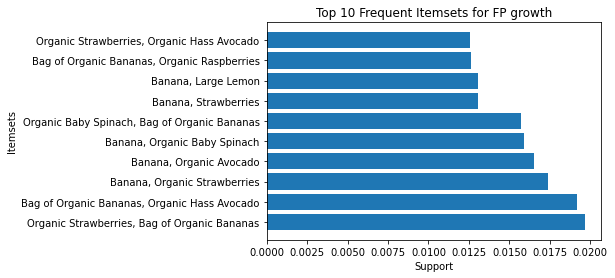

In [52]:
# plot filteeed frequent itemsets for top 10 support values vertical plot

import matplotlib.pyplot as plt

plt.barh(range(10), filtered_frequent_itemsets_fp.sort_values(by='weight', ascending=False).head(10)['weight'], tick_label=filtered_frequent_itemsets_fp.sort_values(by='weight', ascending=False).head(10)['itemsets'].apply(lambda x: ', '.join(x)))
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets for FP growth')
plt.show()


In [67]:
# import networkx and plot network for frequent itemsets

filtered_frequent_itemsets_plot_fp = filtered_frequent_itemsets_fp[['source', 'target', 'weight']].copy().head(25)
filtered_frequent_itemsets_plot_fp

,source,target,weight
103,Organic Hass Avocado,Bag of Organic Bananas,0.019182
104,Organic Hass Avocado,Organic Strawberries,0.012555
105,Organic Hass Avocado,Organic Baby Spinach,0.010616
106,Bag of Organic Bananas,Organic Raspberries,0.012622
107,Organic Raspberries,Organic Strawberries,0.010759
108,Banana,Organic Strawberries,0.017375
109,Bag of Organic Bananas,Organic Strawberries,0.019693
110,Organic Baby Spinach,Organic Strawberries,0.011850
111,Banana,Organic Baby Spinach,0.015904
112,Bag of Organic Bananas,Organic Baby Spinach,0.015717


In [65]:

import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G = nx.from_pandas_edgelist(filtered_frequent_itemsets_plot_fp, 'source', 'target', ['weight'])

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=150, font_size=30, linewidths=0.25, node_color='black', edge_color='blue', pos=pos)
plt.title("Frequent Itemsets using FP-Growth", size=30)
plt.show()

NameError: name 'filtered_frequent_itemsets_plot_fp' is not defined

In [ ]:
import plotly.express as px
# to have a same origin
df_table["all"] = "Top 50 items" 
# creating tree map using plotly
fig = px.treemap(df_table.head(50), path=['all', "items"], values='incident_count',
                  color=df_table["incident_count"].head(50), hover_data=['items'],
                  color_continuous_scale='Blues',
                )
# ploting the treemap
fig.show()

## ECLAT ALGORITHM

In [53]:

def eclat(prefix, items, frequent_itemsets, min_support, transactions_len):
    while items:
        item, tidset = items.pop(0)
        itemset = prefix.copy()
        itemset.add(item)
        support = len(tidset) / transactions_len
        if support >= min_support:

            frequent_itemsets.append((itemset, support))
            suffix = []
            for other_item, other_tidset in items:
                new_tidset = tidset & other_tidset  # Intersection of tidsets
                if len(new_tidset) >= min_support * transactions_len:
                    suffix.append((other_item, new_tidset))

            eclat(itemset, suffix, frequent_itemsets, min_support, transactions_len)


def run_eclat(transactions, min_support):

    data = {}
    transactions_len = len(transactions)
    for i, transaction in enumerate(transactions):
        for item in transaction:
            if item not in data:
                data[item] = set()
            data[item].add(i)

    # Convert to list of tuples and sort by frequency
    sorted_items = sorted(data.items(), key=lambda x: len(x[1]), reverse=True)


    frequent_itemsets = []
    eclat(set(), sorted_items, frequent_itemsets, min_support, transactions_len)
    return frequent_itemsets


min_support_threshold = 0.007 
frequent_itemsets_eclat = run_eclat(transactions, min_support_threshold)

for itemset in frequent_itemsets_eclat:
    if len(itemset[0]) >=2:
        print(f"itemset: {itemset[0]} --> Confidence: {round(itemset[1],3)}")

itemset: {'Banana', 'Organic Strawberries'} --> Confidence: 0.017
itemset: {'Banana', 'Organic Baby Spinach'} --> Confidence: 0.016
itemset: {'Banana', 'Organic Hass Avocado'} --> Confidence: 0.01
itemset: {'Banana', 'Organic Avocado'} --> Confidence: 0.016
itemset: {'Banana', 'Large Lemon'} --> Confidence: 0.013
itemset: {'Banana', 'Strawberries'} --> Confidence: 0.013
itemset: {'Banana', 'Limes'} --> Confidence: 0.01
itemset: {'Banana', 'Organic Raspberries'} --> Confidence: 0.007
itemset: {'Banana', 'Organic Whole Milk'} --> Confidence: 0.01
itemset: {'Banana', 'Cucumber Kirby'} --> Confidence: 0.01
itemset: {'Banana', 'Organic Fuji Apple'} --> Confidence: 0.01
itemset: {'Banana', 'Seedless Red Grapes'} --> Confidence: 0.008
itemset: {'Banana', 'Honeycrisp Apple'} --> Confidence: 0.009
itemset: {'Organic Strawberries', 'Bag of Organic Bananas'} --> Confidence: 0.02
itemset: {'Organic Baby Spinach', 'Bag of Organic Bananas'} --> Confidence: 0.016
itemset: {'Organic Hass Avocado', 'Ba

In [54]:
frequent_itemsets_eclat

[({'Banana'}, 0.14692008336734008),
 ({'Banana', 'Organic Strawberries'}, 0.017374710551784845),
 ({'Banana', 'Organic Baby Spinach'}, 0.01590421198944931),
 ({'Banana', 'Organic Hass Avocado'}, 0.009528142731390493),
 ({'Banana', 'Organic Avocado'}, 0.016486626358901715),
 ({'Banana', 'Large Lemon'}, 0.013071098331871435),
 ({'Banana', 'Strawberries'}, 0.013079697738668718),
 ({'Banana', 'Limes'}, 0.00982755844078683),
 ({'Banana', 'Organic Raspberries'}, 0.007092947079250569),
 ({'Banana', 'Organic Whole Milk'}, 0.009610227978091839),
 ({'Banana', 'Cucumber Kirby'}, 0.009553940951782344),
 ({'Banana', 'Organic Fuji Apple'}, 0.010384956354101683),
 ({'Banana', 'Seedless Red Grapes'}, 0.007827805478291188),
 ({'Banana', 'Honeycrisp Apple'}, 0.008935565426632206),
 ({'Bag of Organic Bananas'}, 0.11812614235301659),
 ({'Bag of Organic Bananas', 'Organic Strawberries'}, 0.01969264156577999),
 ({'Bag of Organic Bananas', 'Organic Baby Spinach'}, 0.015716588568417664),
 ({'Bag of Organic Ba

In [56]:
# Filter the frequent itemsets to only include itemsets with 2 or more items

filtered_frequent_itemsets_eclat = [itemset for itemset in frequent_itemsets_eclat if len(itemset[0]) >= 2]
filtered_frequent_itemsets_eclat

[({'Banana', 'Organic Strawberries'}, 0.017374710551784845),
 ({'Banana', 'Organic Baby Spinach'}, 0.01590421198944931),
 ({'Banana', 'Organic Hass Avocado'}, 0.009528142731390493),
 ({'Banana', 'Organic Avocado'}, 0.016486626358901715),
 ({'Banana', 'Large Lemon'}, 0.013071098331871435),
 ({'Banana', 'Strawberries'}, 0.013079697738668718),
 ({'Banana', 'Limes'}, 0.00982755844078683),
 ({'Banana', 'Organic Raspberries'}, 0.007092947079250569),
 ({'Banana', 'Organic Whole Milk'}, 0.009610227978091839),
 ({'Banana', 'Cucumber Kirby'}, 0.009553940951782344),
 ({'Banana', 'Organic Fuji Apple'}, 0.010384956354101683),
 ({'Banana', 'Seedless Red Grapes'}, 0.007827805478291188),
 ({'Banana', 'Honeycrisp Apple'}, 0.008935565426632206),
 ({'Bag of Organic Bananas', 'Organic Strawberries'}, 0.01969264156577999),
 ({'Bag of Organic Bananas', 'Organic Baby Spinach'}, 0.015716588568417664),
 ({'Bag of Organic Bananas', 'Organic Hass Avocado'}, 0.01918214950772305),
 ({'Bag of Organic Bananas', 'Org

In [57]:
# Create a DataFrame from the filtered frequent itemsets

filtered_frequent_itemsets_eclat_df = pd.DataFrame(filtered_frequent_itemsets_eclat, columns=['itemsets', 'support'])
filtered_frequent_itemsets_eclat_df['source'] = filtered_frequent_itemsets_eclat_df['itemsets'].apply(lambda x: list(x)[0])
filtered_frequent_itemsets_eclat_df['target'] = filtered_frequent_itemsets_eclat_df['itemsets'].apply(lambda x: list(x)[1])
filtered_frequent_itemsets_eclat_df = filtered_frequent_itemsets_eclat_df.rename({'support': 'weight'}, axis='columns')
filtered_frequent_itemsets_eclat_df

,itemsets,weight,source,target
0,"{Banana, Organic Strawberries}",0.017375,Banana,Organic Strawberries
1,"{Banana, Organic Baby Spinach}",0.015904,Banana,Organic Baby Spinach
2,"{Banana, Organic Hass Avocado}",0.009528,Banana,Organic Hass Avocado
3,"{Banana, Organic Avocado}",0.016487,Banana,Organic Avocado
4,"{Banana, Large Lemon}",0.013071,Banana,Large Lemon
5,"{Banana, Strawberries}",0.013080,Banana,Strawberries
6,"{Banana, Limes}",0.009828,Banana,Limes
7,"{Banana, Organic Raspberries}",0.007093,Banana,Organic Raspberries
8,"{Banana, Organic Whole Milk}",0.009610,Banana,Organic Whole Milk
9,"{Banana, Cucumber Kirby}",0.009554,Banana,Cucumber Kirby


In [59]:
filtered_frequent_itemsets_eclat_df.sort_values(by='weight', ascending=False).head(10)

,itemsets,weight,source,target
13,"{Organic Strawberries, Bag of Organic Bananas}",0.019693,Organic Strawberries,Bag of Organic Bananas
15,"{Organic Hass Avocado, Bag of Organic Bananas}",0.019182,Organic Hass Avocado,Bag of Organic Bananas
0,"{Banana, Organic Strawberries}",0.017375,Banana,Organic Strawberries
3,"{Banana, Organic Avocado}",0.016487,Banana,Organic Avocado
1,"{Banana, Organic Baby Spinach}",0.015904,Banana,Organic Baby Spinach
14,"{Organic Baby Spinach, Bag of Organic Bananas}",0.015717,Organic Baby Spinach,Bag of Organic Bananas
5,"{Banana, Strawberries}",0.013080,Banana,Strawberries
4,"{Banana, Large Lemon}",0.013071,Banana,Large Lemon
17,"{Organic Raspberries, Bag of Organic Bananas}",0.012622,Organic Raspberries,Bag of Organic Bananas
24,"{Organic Strawberries, Organic Hass Avocado}",0.012555,Organic Strawberries,Organic Hass Avocado


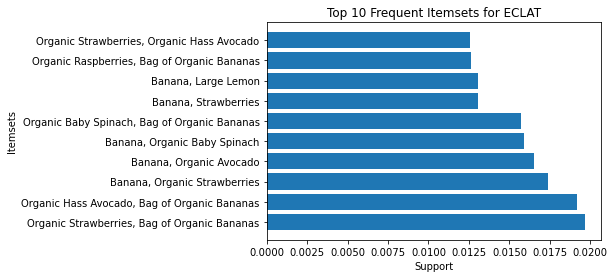

In [58]:
# plot filteeed frequent itemsets for top 10 support values vertical plot

import matplotlib.pyplot as plt

plt.barh(range(10), filtered_frequent_itemsets_eclat_df.sort_values(by='weight', ascending=False).head(10)['weight'], tick_label=filtered_frequent_itemsets_eclat_df.sort_values(by='weight', ascending=False).head(10)['itemsets'].apply(lambda x: ', '.join(x)))
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets for ECLAT')
plt.show()


In [72]:
filtered_frequent_itemsets_eclat_df.sort_values(by='weight', ascending=False).head(10)

,itemsets,weight,source,target
13,"{Bag of Organic Bananas, Organic Strawberries}",0.019693,Bag of Organic Bananas,Organic Strawberries
15,"{Organic Hass Avocado, Bag of Organic Bananas}",0.019182,Organic Hass Avocado,Bag of Organic Bananas
0,"{Banana, Organic Strawberries}",0.017375,Banana,Organic Strawberries
3,"{Banana, Organic Avocado}",0.016487,Banana,Organic Avocado
1,"{Banana, Organic Baby Spinach}",0.015904,Banana,Organic Baby Spinach
14,"{Bag of Organic Bananas, Organic Baby Spinach}",0.015717,Bag of Organic Bananas,Organic Baby Spinach
5,"{Strawberries, Banana}",0.013080,Strawberries,Banana
4,"{Banana, Large Lemon}",0.013071,Banana,Large Lemon
17,"{Bag of Organic Bananas, Organic Raspberries}",0.012622,Bag of Organic Bananas,Organic Raspberries
24,"{Organic Hass Avocado, Organic Strawberries}",0.012555,Organic Hass Avocado,Organic Strawberries


/Users/mdodia/opt/miniconda3/envs/homework1/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  alpha=alpha,


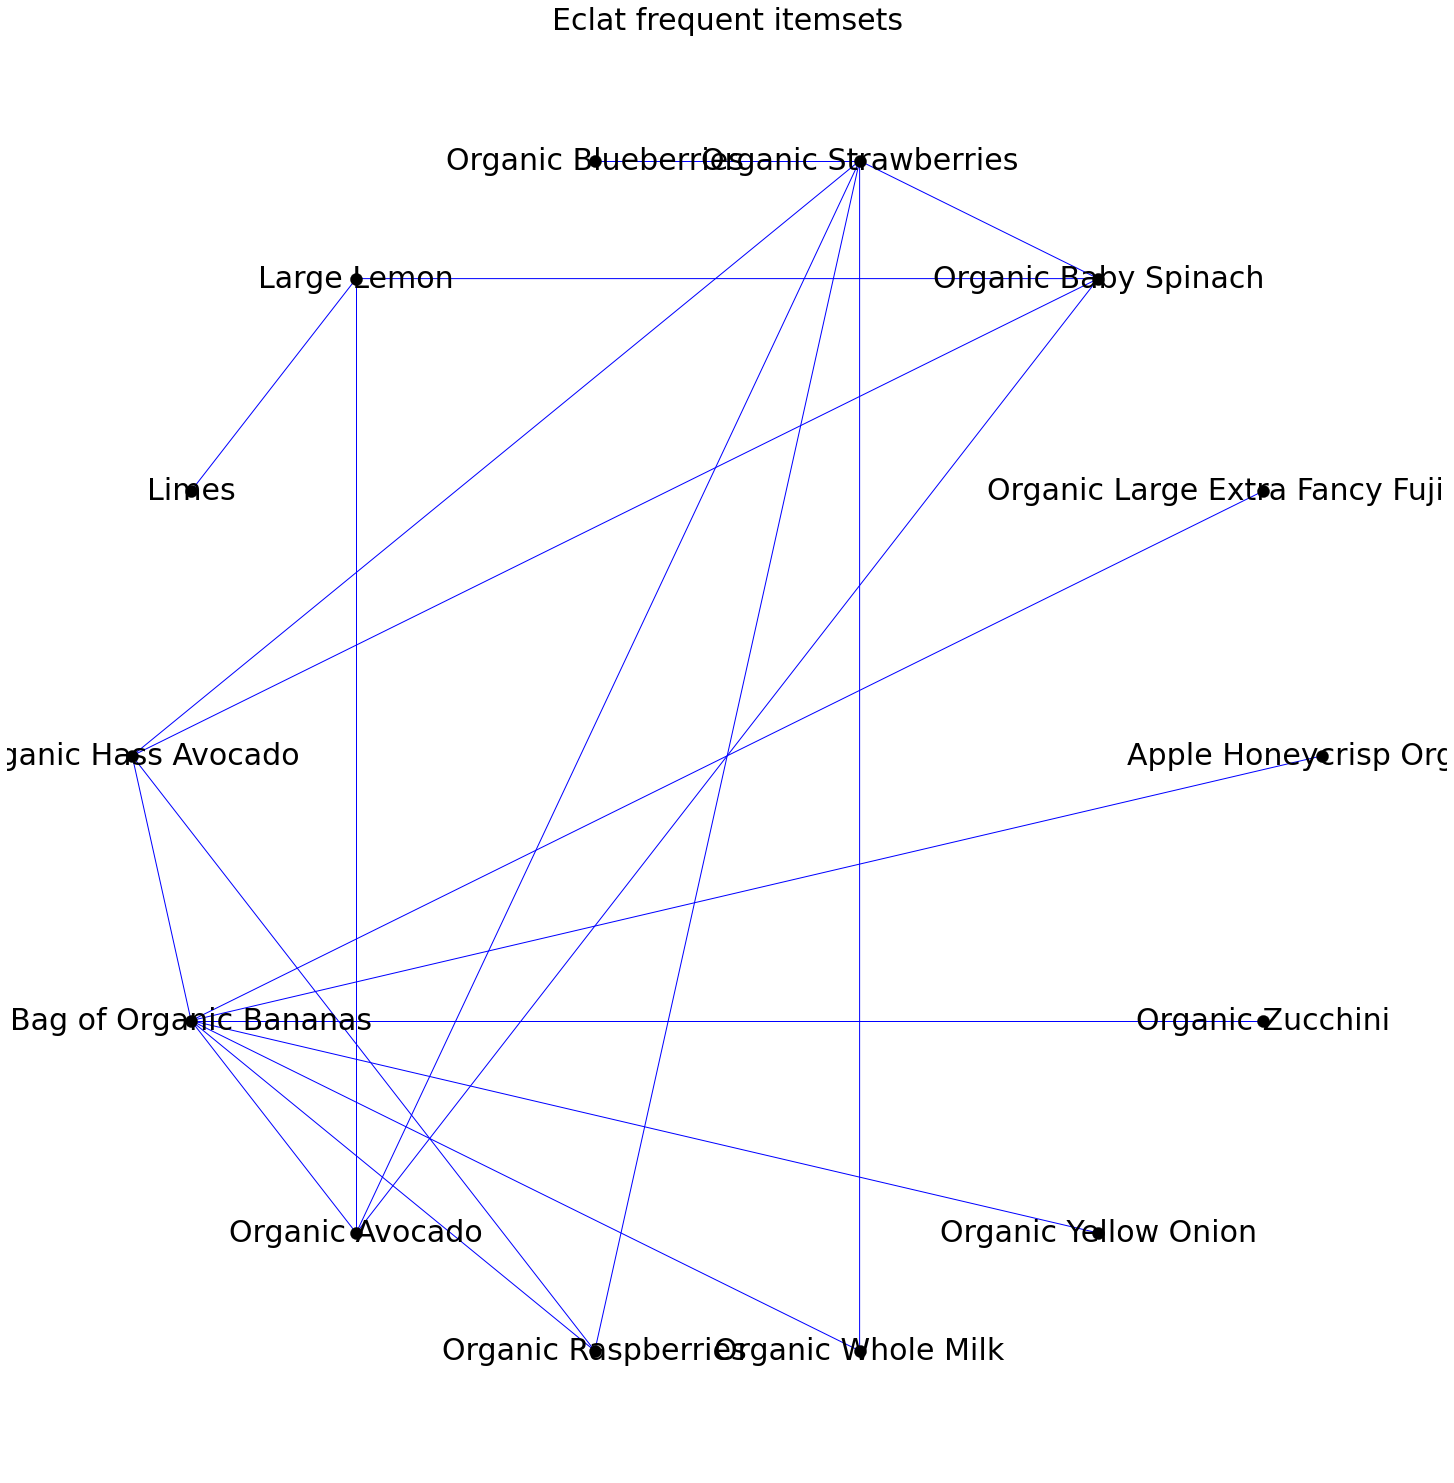

In [55]:
import networkx as nx
import matplotlib.pyplot as plt

filtered_frequent_itemsets_eclat_plot_fp = filtered_frequent_itemsets_eclat_df[['source', 'target', 'weight']].copy().tail(20)

G = nx.Graph()
G = nx.from_pandas_edgelist(filtered_frequent_itemsets_eclat_plot_fp, 'source', 'target', ['weight'])

plt.figure(figsize=(20, 20))
# ax = plt.gca()
# ax.set_title('Random graph')
pos = nx.shell_layout(G)
nx.draw(G, with_labels=True, node_size=150, font_size=30, linewidths=0.25, node_color='black', edge_color='blue', pos=pos)
plt.title('Eclat frequent itemsets', fontsize=30)
plt.show()